In [95]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import yfinance as yf

# Time series decomposition

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [96]:
START_DATE ="2020-01-04"
END_DATE ="2025-12-03"
TICKER ="PPH"
TARGET ="Close_PPH"

In [97]:
ETF_NAME = 'CERN'
ETF_DIRECTORY = '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/'

df = yf.download(TICKER, start=START_DATE, end=END_DATE)
df.head()

df = df.reset_index()  # This moves the index into a column called 'Date'
df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,PPH,PPH,PPH,PPH,PPH
0,2020-01-06,57.221619,57.221619,56.755308,56.809111,179000
1,2020-01-07,56.970528,57.087106,56.943626,56.970528,74200
2,2020-01-08,57.042267,57.257485,56.844981,56.898787,53400
3,2020-01-09,57.391998,57.463740,57.185746,57.185746,61200
4,2020-01-10,57.508579,57.768638,57.463746,57.768638,35100


In [98]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [99]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [100]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [101]:
# MACD components
EMA_12 = df['Close'].ewm(span=12, min_periods=12).mean()
EMA_26 = df['Close'].ewm(span=26, min_periods=26).mean()

df['MACD'] = EMA_12 - EMA_26
df['MACD_signal'] = df['MACD'].ewm(span=9, min_periods=9).mean()

# Plot
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=EMA_26, name='EMA 26'), row=1, col=1)

fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD_signal'], name='Signal line'), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


In [102]:
df['Close'] = df['Close'].shift(-1)

In [103]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [104]:
# ---- Flatten columns BEFORE splitting ----
df.columns = [
    "_".join([str(c) for c in col if c != ""]) if isinstance(col, tuple) else col
    for col in df.columns
]

In [105]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

AttributeError: 'DataFrame' object has no attribute 'Close'

In [106]:
train_df

,Date,Close_PPH,High_PPH,Low_PPH,Open_PPH,Volume_PPH,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-02-24,56.997433,58.611578,57.732760,57.974887,42500,59.492714,59.571097,59.871508,59.537021,59.188787,49.422278,0.067516,0.219426
1,2020-02-25,56.593887,58.477068,56.746340,58.423265,125000,59.326442,59.233919,59.683189,59.563924,59.204928,34.487370,-0.113504,0.144830
2,2020-02-26,54.369957,57.481668,56.414537,57.122970,26100,59.087562,58.737121,59.357670,59.499956,59.187890,25.623329,-0.284142,0.050974
3,2020-02-27,52.953087,56.333838,54.369957,55.607470,117200,58.832447,58.125538,58.971172,59.333759,59.148732,15.952636,-0.582351,-0.085038
4,2020-02-28,55.437080,53.051730,51.787313,52.648192,76600,58.376963,57.112212,58.344344,58.975060,59.001664,14.096256,-0.916460,-0.260996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,2024-03-01,86.405548,86.588863,85.797745,86.183658,256800,85.233778,86.704626,86.341871,85.598349,83.997461,66.269911,1.264488,1.355238
1013,2024-03-04,86.116119,86.878295,86.183653,86.878295,151500,85.366393,86.536757,86.465363,85.777155,84.171121,64.342088,1.203974,1.324985
1014,2024-03-05,86.502022,86.492382,85.855625,86.492382,104300,85.470308,86.372745,86.503954,85.925088,84.337707,66.530600,1.119753,1.283938
1015,2024-03-06,87.572929,86.772159,86.270470,86.492372,141800,85.534889,86.206804,86.533862,86.046007,84.484996,65.254187,1.071792,1.241509


In [107]:
train_df

,Date,Close_PPH,High_PPH,Low_PPH,Open_PPH,Volume_PPH,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-02-24,56.997433,58.611578,57.732760,57.974887,42500,59.492714,59.571097,59.871508,59.537021,59.188787,49.422278,0.067516,0.219426
1,2020-02-25,56.593887,58.477068,56.746340,58.423265,125000,59.326442,59.233919,59.683189,59.563924,59.204928,34.487370,-0.113504,0.144830
2,2020-02-26,54.369957,57.481668,56.414537,57.122970,26100,59.087562,58.737121,59.357670,59.499956,59.187890,25.623329,-0.284142,0.050974
3,2020-02-27,52.953087,56.333838,54.369957,55.607470,117200,58.832447,58.125538,58.971172,59.333759,59.148732,15.952636,-0.582351,-0.085038
4,2020-02-28,55.437080,53.051730,51.787313,52.648192,76600,58.376963,57.112212,58.344344,58.975060,59.001664,14.096256,-0.916460,-0.260996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,2024-03-01,86.405548,86.588863,85.797745,86.183658,256800,85.233778,86.704626,86.341871,85.598349,83.997461,66.269911,1.264488,1.355238
1013,2024-03-04,86.116119,86.878295,86.183653,86.878295,151500,85.366393,86.536757,86.465363,85.777155,84.171121,64.342088,1.203974,1.324985
1014,2024-03-05,86.502022,86.492382,85.855625,86.492382,104300,85.470308,86.372745,86.503954,85.925088,84.337707,66.530600,1.119753,1.283938
1015,2024-03-06,87.572929,86.772159,86.270470,86.492372,141800,85.534889,86.206804,86.533862,86.046007,84.484996,65.254187,1.071792,1.241509


In [108]:
drop_cols = ['Open_PPH', 'High_PPH', 'Low_PPH', 'Volume_PPH']

train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

In [111]:
train_df

,Date,Close_PPH,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-02-24,56.997433,59.492714,59.571097,59.871508,59.537021,59.188787,49.422278,0.067516,0.219426
1,2020-02-25,56.593887,59.326442,59.233919,59.683189,59.563924,59.204928,34.487370,-0.113504,0.144830
2,2020-02-26,54.369957,59.087562,58.737121,59.357670,59.499956,59.187890,25.623329,-0.284142,0.050974
3,2020-02-27,52.953087,58.832447,58.125538,58.971172,59.333759,59.148732,15.952636,-0.582351,-0.085038
4,2020-02-28,55.437080,58.376963,57.112212,58.344344,58.975060,59.001664,14.096256,-0.916460,-0.260996
...,...,...,...,...,...,...,...,...,...,...
1012,2024-03-01,86.405548,85.233778,86.704626,86.341871,85.598349,83.997461,66.269911,1.264488,1.355238
1013,2024-03-04,86.116119,85.366393,86.536757,86.465363,85.777155,84.171121,64.342088,1.203974,1.324985
1014,2024-03-05,86.502022,85.470308,86.372745,86.503954,85.925088,84.337707,66.530600,1.119753,1.283938
1015,2024-03-06,87.572929,85.534889,86.206804,86.533862,86.046007,84.484996,65.254187,1.071792,1.241509


In [112]:
y_train = train_df['Close_PPH'].copy()
X_train = train_df.drop(['Close_PPH'], axis=1)

y_valid = valid_df['Close_PPH'].copy()
X_valid = valid_df.drop(['Close_PPH'], axis=1)

y_test = test_df['Close_PPH'].copy()
X_test = test_df.drop(['Close_PPH'], axis=1)

In [114]:
X_train = X_train.drop(columns=['Date'])
X_valid = X_valid.drop(columns=['Date'])
X_test  = X_test.drop(columns=['Date'])

In [115]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

/Users/arnaudthomas/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning:

[17:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "eval_set", "verbose" } are not used.


/Users/arnaudthomas/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning:

[17:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "eval_set", "verbose" } are not used.


/Users/arnaudthomas/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning:

[17:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "eval_set", "verbose" } are not used.


/Users/arnaudthomas/.pyenv/versions/3.10.6/envs/StockProphet/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning:

[17:58:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "eva

Best params: {'gamma': 0.02, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = -0.1778273526371185
CPU times: user 7min 52s, sys: 9min 28s, total: 17min 20s
Wall time: 9min 25s


In [116]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 253 ms, sys: 300 ms, total: 553 ms
Wall time: 295 ms


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


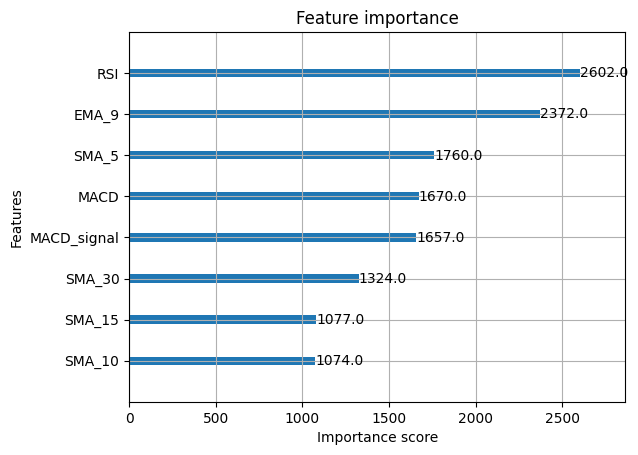

In [117]:
plot_importance(model);

In [118]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [85.39063263 86.22624969 88.31039429 87.3469696  86.9340744 ]
y_pred = [85.084175 85.08656  85.080215 85.789536 85.46157 ]


In [119]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 28.634662804610905


In [123]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close_PPH'] = y_pred

fig = make_subplots(rows=2, cols=1)

# 1) Truth (full dataset)
fig.add_trace(go.Scatter(
    x=df.Date, 
    y=df.Close_PPH,
    name='Truth',
    marker_color='LightSkyBlue'
), row=1, col=1)

# 2) Predictions on test set (overlay)
fig.add_trace(go.Scatter(
    x=predicted_prices.Date,
    y=predicted_prices.Close_PPH,
    name='Prediction',
    marker_color='MediumPurple'
), row=1, col=1)

# 3) Truth on test set only
fig.add_trace(go.Scatter(
    x=predicted_prices.Date,
    y=y_test,
    name='Truth (Test)',
    marker_color='LightSkyBlue',
    showlegend=False
), row=2, col=1)

# 4) Predictions on test only
fig.add_trace(go.Scatter(
    x=predicted_prices.Date,
    y=y_pred,
    name='Prediction (Test)',
    marker_color='MediumPurple',
    showlegend=False
), row=2, col=1)

fig.show()
